# Capstone 5: Part 3 Yearly Solar data ARMA Model
## By Elizabeth Tyree


### Problem Statement:
### Can the occurrence of sunspots be used to predict the frequency of earthquakes?

In [2]:
# Importing Libraries

import numpy as np
np.random.seed(19680801)

import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import datetime as dt
from datetime import timedelta
from datetime import datetime
import time
#from datetime import now

#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 # Use this at the command line to expand rate limit!
# or the function prep_posts may not work properly.
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None) 
%matplotlib inline

## Note: This Data Cleaning and EDA section repeats, then the ARMA Model follows it.

In [3]:
# Loading the Yearly mean sunspot data, these are the yearly mean sunspot numbers.
# Data dictionary that is copied and pasted below, can be found here: http://www.sidc.be/silso/infosndtot
# Sunspot data source: SILSO data, Royal Observatory of Belgium, Brussels.
'''
Time range: 1700 - last elapsed year

Data description:
Yearly mean total sunspot number obtained by taking a simple arithmetic mean of the daily total sunspot number over all days of each year. (NB: in early years in particular before 1749, the means are computed on only a fraction of the days in each year because on many days, no observation is available).

Error values:
The yearly standard deviation of individual data is derived from the daily values by the same formula as the monthly means:
sigma(m)=sqrt(SUM(N(d)*sigma(d)^2)/SUM(N(d)))
where sigma(d) is the standard deviation for a single day and N(d) is the
number of observations for that day.

The standard error on the yearly mean values can be computed by:
sigma/sqrt(N) where sigma is the listed standard deviation and N the total number of observations in the year.
NB: this standard error gives a measure of the precision, i.e. the sensitivity of the yearly value to different samples of daily values with random errors. The uncertainty on the mean (absolute accuracy) is only determined on longer time scales, and is thus not given here for individual yearly values.

-------------------------------------------------------------------------------
TXT
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.txt
Format: plain ASCII text

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the yearly average still contains provisional daily values and is subject to a possible revision.

Line format [character position]:
- [1-6] Year (decimal)
- [9-13] Yearly mean total sunspot number
- [15-19] Standard deviation
- [22-26] Number of observations
- [28] Definitive/provisional indicator

-------------------------------------------------------------------------------
CSV
-------------------------------------------------------------------------------
Filename: SN_y_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
Column 1: Gregorian calendar year (mid-year date)
Column 2: Yearly mean total sunspot number.
Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
Column 4: Number of observations used to compute the yearly mean total sunspot number.
Column 5: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.
''';

# Headers for the sunspot data.
my_cols_y = ['Frac_Year','Yearly_Mean_Sunspot_Number','y_Std','Number_of_observations', 'Definitive_provisional_indicator'] # The file does not contain headers.

# Loading the data file
ISSN_Y_tot = pd.read_csv('./data/SN_y_tot_V2.0.csv',names=my_cols_y,sep=';', engine='python')

In [4]:
ISSN_Y_tot.head() # Checking that the data loaded properly by viewing the head.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [5]:
ISSN_Y_tot.head() # Viewing the head of the sunspot data.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [6]:
ISSN_Y_tot.tail() # Viewing the tail of the sunspot data

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


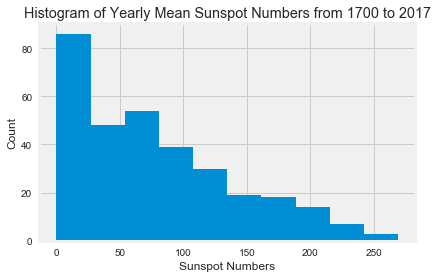

In [7]:
# Histogram of Yearly mean Sunspot Numbers from the ISSN.
#bin_size = 0.5
#n_bins = 10/bin_size


plt.hist(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'])    
# Add title and axis names
plt.title('Histogram of Yearly Mean Sunspot Numbers from 1700 to 2017')
plt.xlabel('Sunspot Numbers') #Default is 10 bins
plt.ylabel('Count')
#plt.xlim(0,10)

# Show graphic
plt.show()

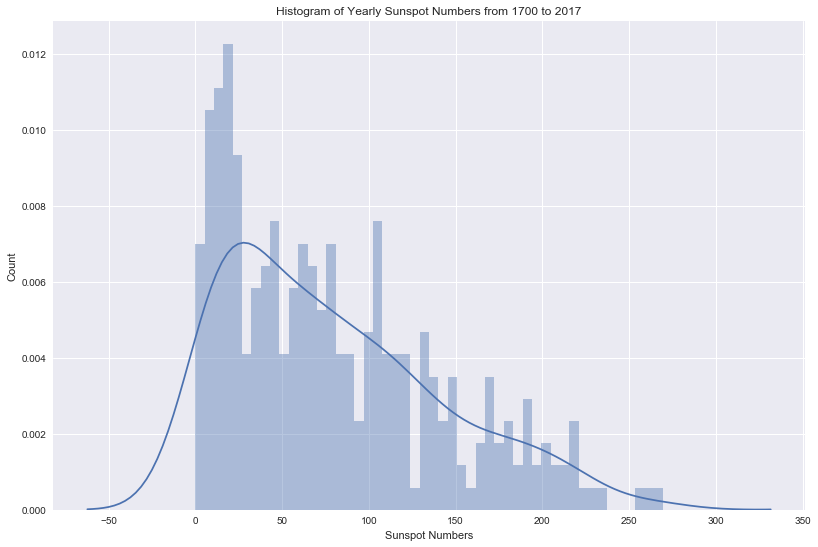

In [8]:
sns.set(rc={'figure.figsize':(12,9)})
f,ax = plt.subplots()
sns.distplot(ISSN_Y_tot['Yearly_Mean_Sunspot_Number'], bins=50, axlabel ='Sunspot Numbers')
ax.set_title('Histogram of Yearly Sunspot Numbers from 1700 to 2017')
ax.set_xlabel('Sunspot Numbers');
ax.set_ylabel('Count');

In [9]:
# Crosstab of Sunspot numbers.
pd.crosstab(index=ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],  # Make a crosstab
                      columns="count")      # Name the count column

col_0,count
Yearly_Mean_Sunspot_Number,
0.0,3
2.2,1
2.3,1
2.4,1
3.3,1
4.2,2
4.6,1
4.8,1
5.0,1


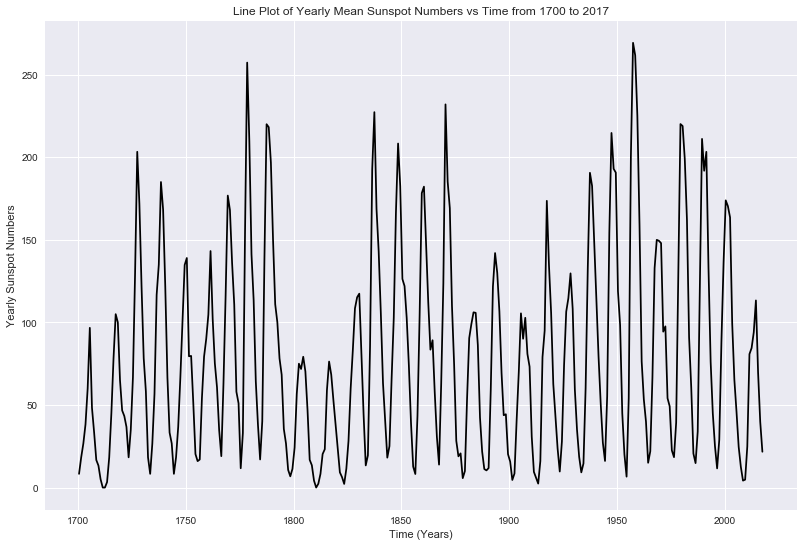

In [10]:
# Plotting the Sunspot numbers vs time in Years.
plt.plot(ISSN_Y_tot['Frac_Year'],ISSN_Y_tot['Yearly_Mean_Sunspot_Number'],'k-')

# Add title and axis names
plt.title('Line Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2017')
plt.xlabel('Time (Years)') #Default is 10 bins
plt.ylabel('Yearly Sunspot Numbers')
#plt.xlim(0,10)

# Show graphic
plt.show()

## Using Yearly Average Sunspot Numbers for Model 1: ARMA.

In [11]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Preparing to decompose the time stamp

In [12]:
ISSN_Y_tot.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [13]:
ISSN_Y_tot.tail()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
313,2013.5,94.0,6.9,5347,1
314,2014.5,113.3,8.0,5273,1
315,2015.5,69.8,6.4,8903,1
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1


### Decomposing the Time stamp

In [14]:
yearly_sun = ISSN_Y_tot.copy() # Making a copy of the sunspot data.

# Creating a new Date feature
yearly_sun['Date'] = yearly_sun['Frac_Year'].astype(int) # Converting the fraction year to an integer.
yearly_sun['Date'] = pd.to_datetime(yearly_sun['Date'], format='%Y') # Converting data type to a timedate type.
delta_t = datetime(1701,1,1) - datetime(1700,1,1) # delta_t is 1 year.


yearly_sun['Date'] = yearly_sun.Date + delta_t # Adding delta_t to the date
yearly_sun.set_index('Date', inplace=True) # Setting the Date column as the index.


In [15]:
yearly_sun.head() # Viewing the head to see if the changes persisted.

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator
Date,,,,,
1701-01-01,1700.5,8.3,-1.0,-1,1
1702-01-01,1701.5,18.3,-1.0,-1,1
1703-01-01,1702.5,26.7,-1.0,-1,1
1704-01-01,1703.5,38.3,-1.0,-1,1
1704-12-31,1704.5,60.0,-1.0,-1,1


In [16]:
yearly_sun.index # Verifying the Date is now a Datetime Index

DatetimeIndex(['1701-01-01', '1702-01-01', '1703-01-01', '1704-01-01',
               '1704-12-31', '1706-01-01', '1707-01-01', '1708-01-01',
               '1708-12-31', '1710-01-01',
               ...
               '2008-12-31', '2010-01-01', '2011-01-01', '2012-01-01',
               '2012-12-31', '2014-01-01', '2015-01-01', '2016-01-01',
               '2016-12-31', '2018-01-01'],
              dtype='datetime64[ns]', name='Date', length=318, freq=None)

In [17]:
# Setting the frequency to be yearly for the index.
yearly_sun.index = pd.date_range('1/1/1700', 
                          periods=len(yearly_sun.index),name='Date', freq='Y')

In [18]:
yearly_sun.index # Making sure the "freq=None" has changed to "freq='A-DEC'".

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq='A-DEC')

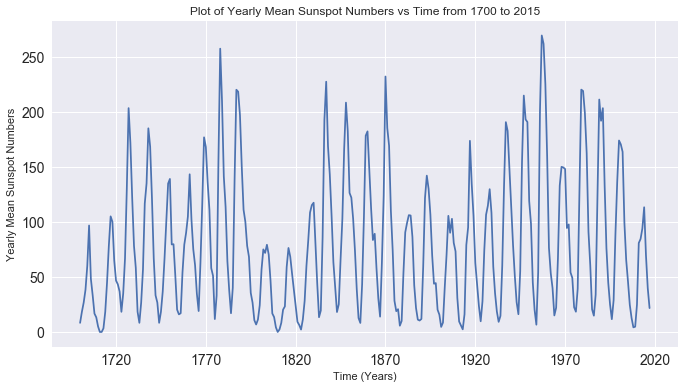

In [19]:
# Plotting the yearly mean sunspot numbers vs. time in Years.
yearly_sun.Yearly_Mean_Sunspot_Number.plot(figsize=(10,6), title= 'Plot of Yearly Mean Sunspot Numbers vs Time from 1700 to 2015', fontsize=14)
plt.xlabel('Time (Years)'); 
plt.ylabel('Yearly Mean Sunspot Numbers');

## Pre Model Staging: 
## Decomposing the Time Series data, looking at the plots for trends and seasonality 

In [20]:
yearly_sun.dtypes

Frac_Year                           float64
Yearly_Mean_Sunspot_Number          float64
y_Std                               float64
Number_of_observations                int64
Definitive_provisional_indicator      int64
dtype: object

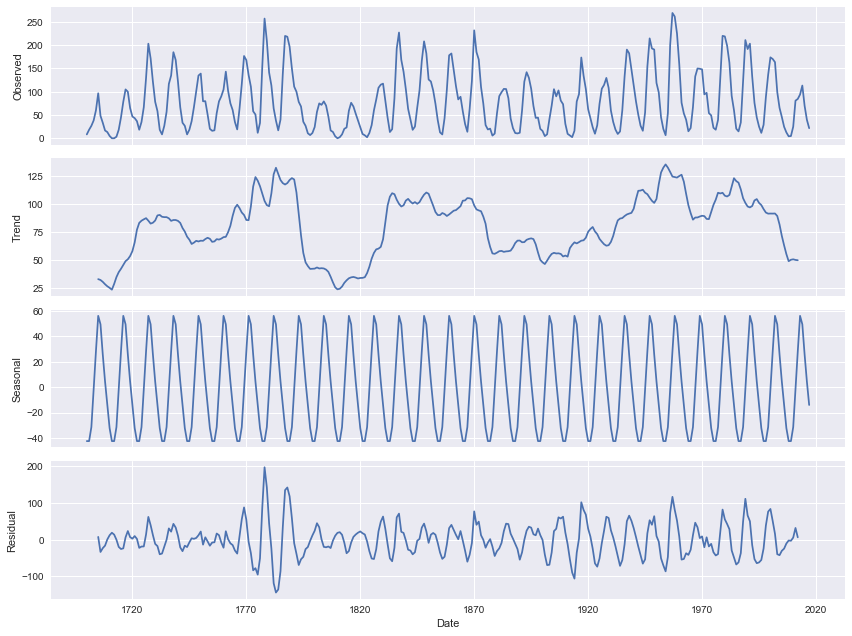

In [21]:
decomposition = seasonal_decompose(yearly_sun.Yearly_Mean_Sunspot_Number, freq=11)# You originally had 11 for one solar cycle.
decomposition.plot();

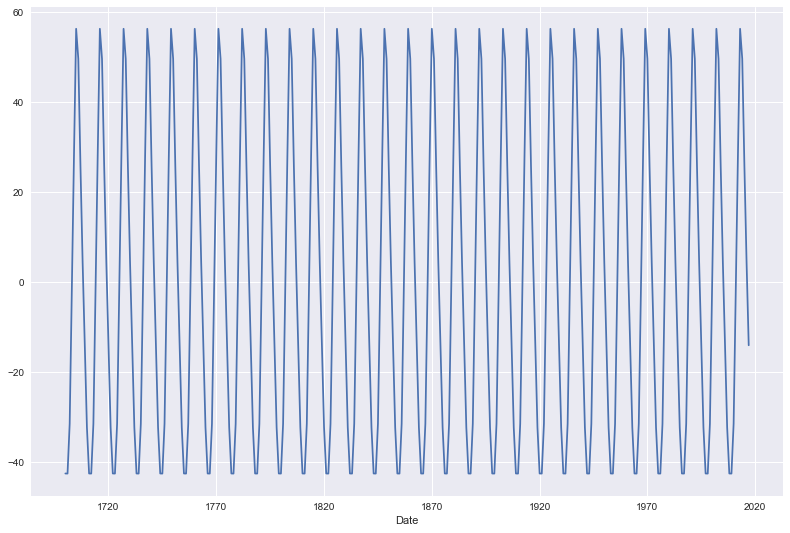

In [22]:
# Ploting only the seasonal componet
seasonal = decomposition.seasonal 
seasonal.plot()

## Utilizing the Dickey-Fuller test for stationartity of the data series.

In [23]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=11, center=False).mean()
    rolstd = timeseries.rolling(window=11, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = timeseries.plot(color='blue',label='Original')
    mean = rolmean.plot(color='red', label='Rolling Mean')
    std = rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )


###### Perform the test.
test_stationarity(yearly_sun.Yearly_Sun_Spot_Number)

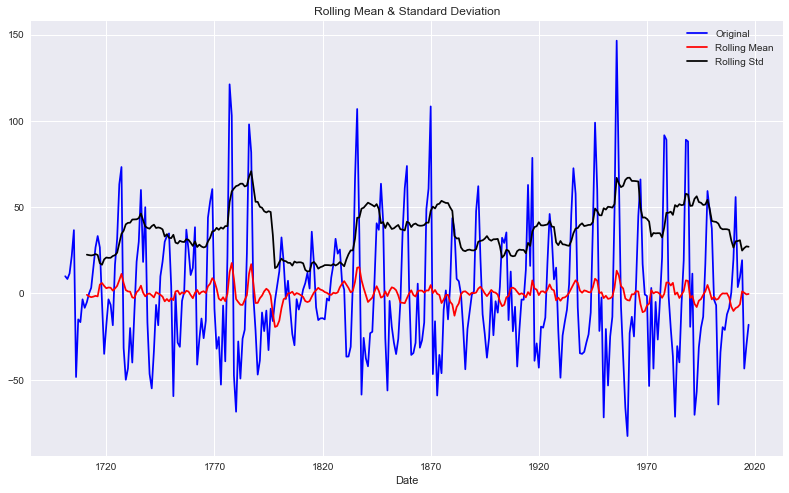

Results of Dickey-Fuller Test:
Test Statistic   -1.486027e+01
p-value           1.723470e-27
dtype: float64


In [24]:
# First difference:
yearly_sun['first_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff()
test_stationarity(yearly_sun.first_difference.dropna())

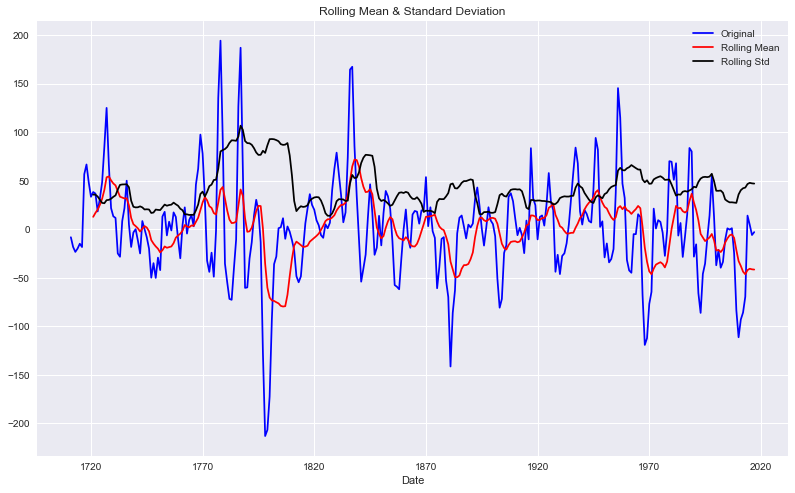

Results of Dickey-Fuller Test:
Test Statistic   -4.351080
p-value           0.000362
dtype: float64


In [25]:
# Seasonal difference:
yearly_sun['seasonal_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_difference.dropna())

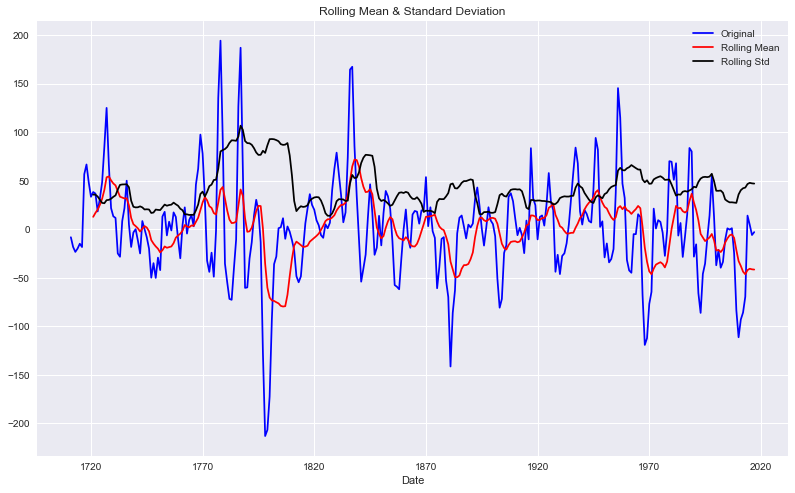

Results of Dickey-Fuller Test:
Test Statistic   -4.351080
p-value           0.000362
dtype: float64


In [26]:
# First seasonal difference:
yearly_sun['seasonal_first_difference'] = yearly_sun.Yearly_Mean_Sunspot_Number.diff(11)  
test_stationarity(yearly_sun.seasonal_first_difference.dropna())

## Training and Perdicting with ARMA Model for Solar Seasonal First Difference

In [27]:
train_test = yearly_sun.copy()
train_test.dropna(inplace=True)

In [28]:
from statsmodels.tsa.arima_model import ARMA

train = train_test.head(290)
test = train_test.tail(17)

p = 1  # number of previous time points to use in the AR
q = 0  # MA parameter

model = ARMA(train.seasonal_first_difference, (p,q)).fit()
model.summary()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     seasonal_first_difference   No. Observations:                  290
Model:                            ARMA(1, 0)   Log Likelihood               -1441.364
Method:                              css-mle   S.D. of innovations             34.811
Date:                       Wed, 18 Jul 2018   AIC                           2888.729
Time:                               00:01:11   BIC                           2899.738
Sample:                           12-31-1711   HQIC                          2893.140
                                - 12-31-2000                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.0941      7.766      0.270      0.788     -13.128      17.316
ar.L1.seasonal_first_difference     0.7393      0.039     18.839      0.000       0.662       0.816
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3526           +0.0000j            1.3526            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
len(test)

17

In [30]:
train.tail(2)

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1999-12-31,1999.5,136.3,9.3,6413,1,48.0,13.3,13.3
2000-12-31,2000.5,173.9,10.1,5953,1,37.6,-37.2,-37.2


In [31]:
test.head(2)

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7


In [32]:
#test.reset_index(inplace=True)
test.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7
2003-12-31,2003.5,99.3,7.1,7087,1,-64.3,-33.7,-33.7
2004-12-31,2004.5,65.3,5.9,6882,1,-34.0,-10.8,-10.8
2005-12-31,2005.5,45.8,4.7,7084,1,-19.5,0.9,0.9


In [33]:
# Setting Start and End times for the prediction

In [34]:
start = test.index[0].to_pydatetime()
start

datetime.datetime(2001, 12, 31, 0, 0)

In [35]:
end = test.index[-1].to_pydatetime()
end

datetime.datetime(2017, 12, 31, 0, 0)

In [36]:
test.index


DatetimeIndex(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='A-DEC')

In [37]:
test.index

DatetimeIndex(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='A-DEC')

In [38]:
# Making ARMA predictions on test data
predictions_oos = model.predict(start=start, end=end, dynamic=True)


/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [39]:
len(test)

17

In [40]:
start = test.index[0].to_pydatetime()
end = test.index[-1].to_pydatetime()

#start = len(train) - 1
#end = start + len(test) - 1

predictions_oos = model.predict(start=start, end=end)
truth = test.seasonal_first_difference
model.forecast()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


(array([-26.95648546]),
 array([34.81052174]),
 array([[-95.18385436,  41.27088344]]))

In [41]:
truth = test.seasonal_first_difference


In [42]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(truth, predictions_oos))

32.90943629424748


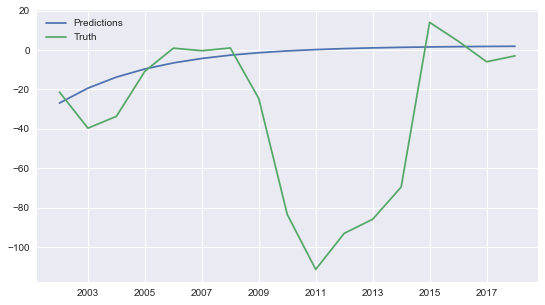

In [43]:
plt.subplots(figsize=(8,5))
plt.plot(truth.index, predictions_oos, label='Predictions')
plt.plot(truth.index, truth.values, label='Truth')
plt.legend()

In [44]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: ARMA
===============================================================================
Model:                ARMA                      BIC:                 2899.7384 
Dependent Variable:   seasonal_first_difference Log-Likelihood:      -1441.4   
Date:                 2018-07-18 00:01          Scale:               1.0000    
No. Observations:     290                       Method:              css-mle   
Df Model:             2                         Sample:              12-31-1711
Df Residuals:         288                                            12-31-2000
Converged:            1.0000                    S.D. of innovations: 34.811    
AIC:                  2888.7287                 HQIC:                2893.140  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-------------------------------------------------------------------------------
const                           2.0941   7.7664  0.2696 0.7876 -13.1277 17.3160
ar.L1.seasonal_first_difference 0.7393   0.0392 18.8387 0.0000   0.6624  0.8162
--------------------------------------------------------------------------------------------
                    Real               Imaginary              Modulus              Frequency
--------------------------------------------------------------------------------------------
AR.1               1.3526                 0.0000               1.3526                 0.0000
===============================================================================

"""

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


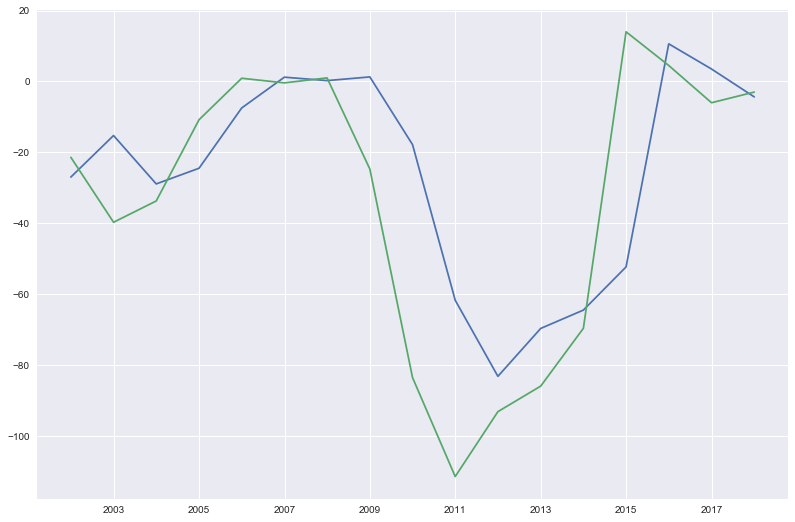

In [45]:
predictions_rolling = []
training_observations = list(train.seasonal_first_difference.values)
testing_observations = test.seasonal_first_difference.values

for obs in testing_observations:
    model_roll = ARMA(training_observations, (1,0)).fit(disp=0)
    predictions_rolling.append(model_roll.forecast()[0][0])
    training_observations.append(obs)
    
plt.plot(test.index, predictions_rolling, label='Fitted')
plt.plot(test.index, testing_observations, label='Truth')

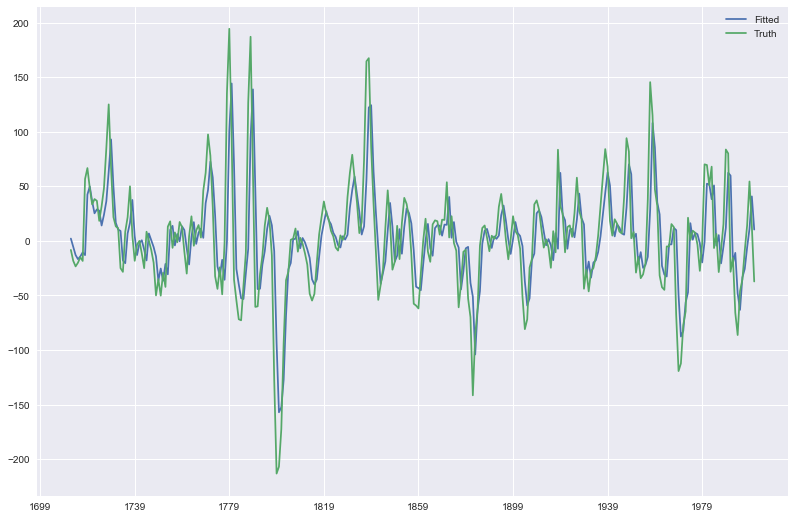

In [46]:
plt.plot(train.index, model.fittedvalues, label='Fitted')
plt.plot(train.index, train.seasonal_first_difference.values, label='Truth')
plt.legend()

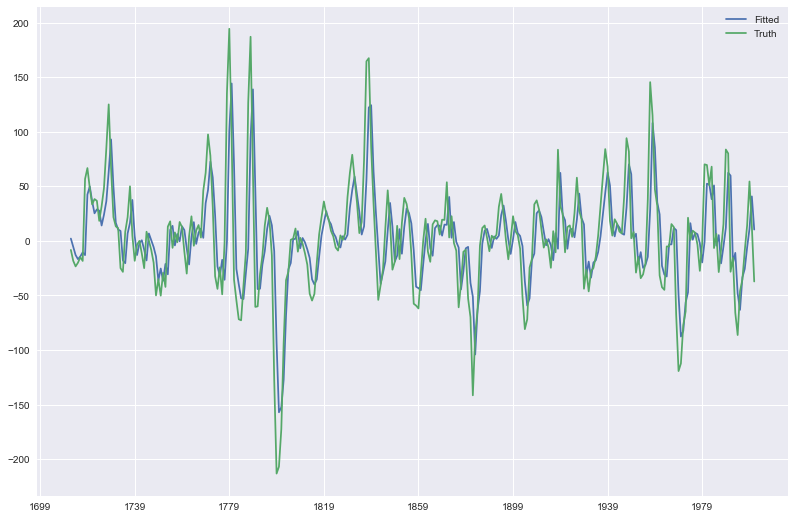

In [47]:
plt.plot(train.index, model.fittedvalues, label='Fitted')
plt.plot(train.index, train.seasonal_first_difference.values, label='Truth')
plt.legend()

In [48]:
 # You wanted to ask Justin how to transform values back to sunspot numbers for the ARMA. 
# Or are they already sunspot numbers?


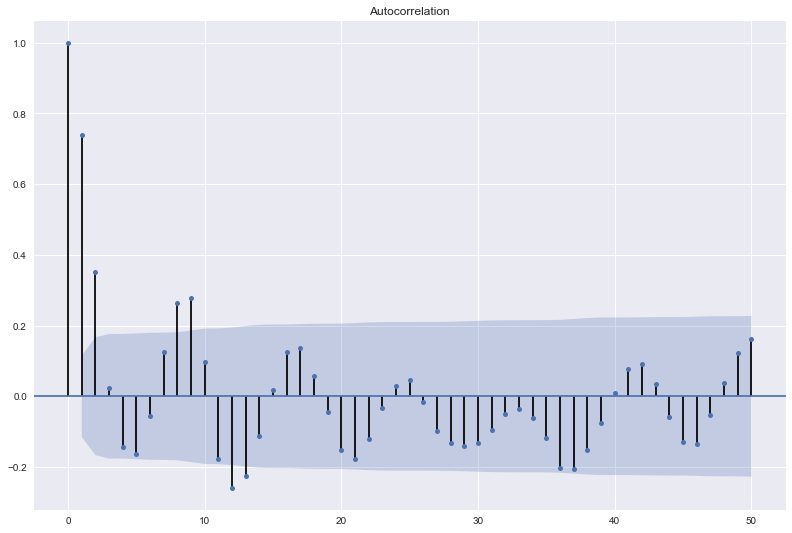

In [49]:
plot_acf(train.seasonal_first_difference.values,lags=50);

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf

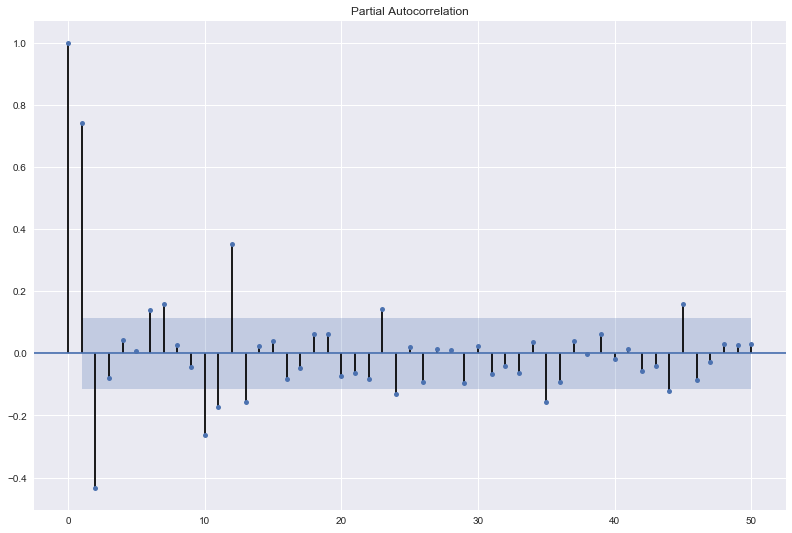

In [51]:
plot_pacf(train.seasonal_first_difference.values, lags=50);

In [52]:
test.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
2001-12-31,2001.5,170.4,10.5,6558,1,-3.5,-21.4,-21.4
2002-12-31,2002.5,163.6,9.8,6588,1,-6.8,-39.7,-39.7
2003-12-31,2003.5,99.3,7.1,7087,1,-64.3,-33.7,-33.7
2004-12-31,2004.5,65.3,5.9,6882,1,-34.0,-10.8,-10.8
2005-12-31,2005.5,45.8,4.7,7084,1,-19.5,0.9,0.9


In [53]:
predictions_oos

2001-12-31   -26.956485
2002-12-31   -19.383333
2003-12-31   -13.784411
2004-12-31    -9.645061
2005-12-31    -6.584790
2006-12-31    -4.322295
2007-12-31    -2.649606
2008-12-31    -1.412966
2009-12-31    -0.498704
2010-12-31     0.177221
2011-12-31     0.676940
2012-12-31     1.046389
2013-12-31     1.319526
2014-12-31     1.521460
2015-12-31     1.670753
2016-12-31     1.781126
2017-12-31     1.862727
Freq: A-DEC, dtype: float64

In [54]:
predictions = model.predict()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [55]:
len(predictions)

290

In [56]:
 len(yearly_sun.Yearly_Mean_Sunspot_Number) - len(predictions)

28

In [57]:
yearly_sun.index

DatetimeIndex(['1700-12-31', '1701-12-31', '1702-12-31', '1703-12-31',
               '1704-12-31', '1705-12-31', '1706-12-31', '1707-12-31',
               '1708-12-31', '1709-12-31',
               ...
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=318, freq='A-DEC')

In [58]:
yearly_sun.head()

,Frac_Year,Yearly_Mean_Sunspot_Number,y_Std,Number_of_observations,Definitive_provisional_indicator,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,,,,,
1700-12-31,1700.5,8.3,-1.0,-1,1,NaN,NaN,NaN
1701-12-31,1701.5,18.3,-1.0,-1,1,10.0,NaN,NaN
1702-12-31,1702.5,26.7,-1.0,-1,1,8.4,NaN,NaN
1703-12-31,1703.5,38.3,-1.0,-1,1,11.6,NaN,NaN
1704-12-31,1704.5,60.0,-1.0,-1,1,21.7,NaN,NaN


In [59]:
len(yearly_sun.seasonal_first_difference[11:])

307

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


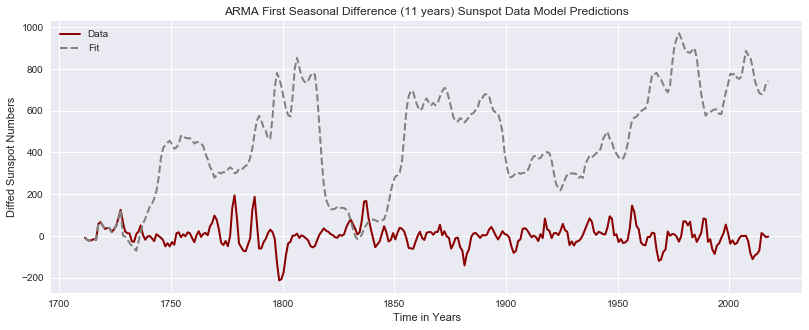

In [60]:
predictions = model.predict() # This is the prediction of the full data after undoing the first diff.
full_pred = pd.concat([yearly_sun.seasonal_first_difference[11:28], pd.DataFrame(np.cumsum(predictions))], axis=0)
# full_pred = pd.concat([yearly_sun.first_difference[0:28], pd.DataFrame(np.cumsum(predictions))], axis=0)

date_ticks = yearly_sun.Frac_Year[11:]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks, yearly_sun.seasonal_first_difference[11:], lw=2, color='darkred', label='Data')
ax.plot(date_ticks, full_pred, lw=2, color='grey', ls='dashed', label='Fit')


plt.title('ARMA First Seasonal Difference (11 years) Sunspot Data Model Predictions')
plt.ylabel('Diffed Sunspot Numbers') 
plt.xlabel('Time in Years')


plt.legend()
plt.show()

In [61]:
y_sun = yearly_sun.Yearly_Mean_Sunspot_Number
y_sun_diff = y_sun.diff(11).dropna()

undo_diff = []
undo_diff.append(y_sun[0:11])


for val in y_sun_diff:
    undo_diff.append(val + undo_diff[-1])  
    
    
undo_diff;

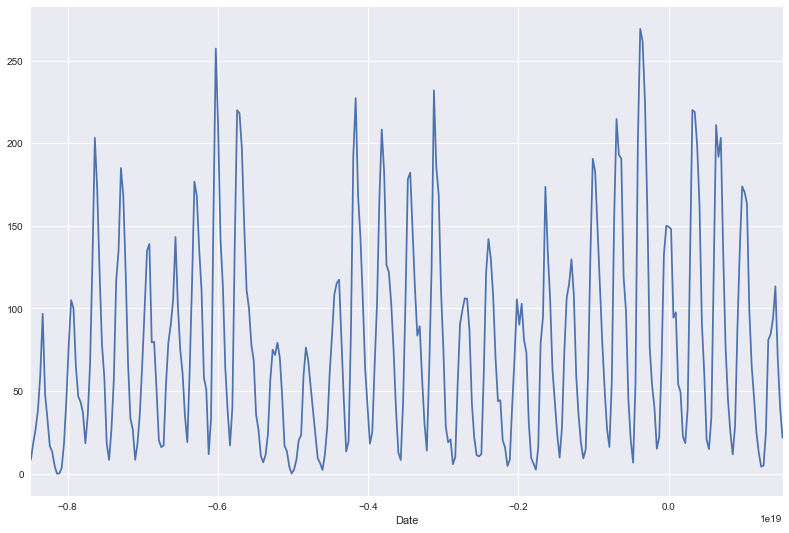

In [62]:
sns.tsplot(yearly_sun.Yearly_Mean_Sunspot_Number,time=yearly_sun.index)

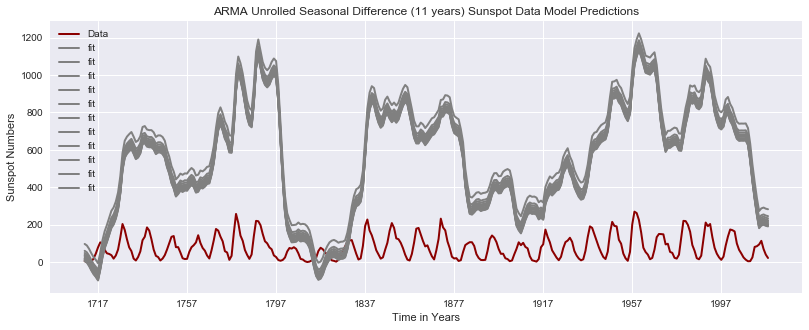

In [63]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(yearly_sun.index[10:], yearly_sun.Yearly_Mean_Sunspot_Number[10:], lw=2, color='darkred', label='Data')
ax.plot(yearly_sun.index[10:], undo_diff[:], lw=2, color='grey', label='fit')
title = 'ARMA Unrolled Seasonal Difference (11 years) Sunspot Data Model Predictions';
plt.title(title)
plt.ylabel('Sunspot Numbers') 
plt.xlabel('Time in Years')

plt.legend()
plt.show()

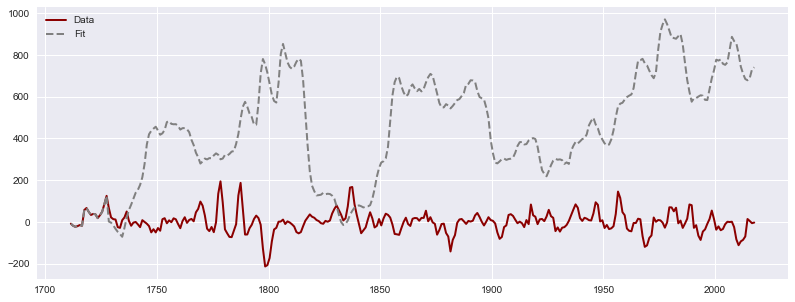

In [64]:

#plt.plot(yearly_sun.index[10:],undo_diff[:]);
date_ticks = yearly_sun.Frac_Year[11:]



fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks, yearly_sun.seasonal_first_difference[11:], lw=2, color='darkred', label='Data')
ax.plot(date_ticks, full_pred, lw=2, color='grey', ls='dashed', label='Fit')



plt.legend()
plt.show()

## Predicting Yearly Mean Sunspot Numbers with ARMA

In [65]:
train = train_test.head(290)
test = train_test.tail(17)

p = 1  # number of previous time points to use in the AR
q = 0  # MA parameter

model = ARMA(train.Yearly_Mean_Sunspot_Number, (p,q)).fit()
model.summary()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                  
======================================================================================
Dep. Variable:     Yearly_Mean_Sunspot_Number   No. Observations:                  290
Model:                             ARMA(1, 0)   Log Likelihood               -1456.212
Method:                               css-mle   S.D. of innovations             36.620
Date:                        Wed, 18 Jul 2018   AIC                           2918.424
Time:                                00:01:26   BIC                           2929.434
Sample:                            12-31-1711   HQIC                          2922.835
                                 - 12-31-2000                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               81.8784     11.413      7.174      0.000      59.510     104.247
ar.L1.Yearly_Mean_Sunspot_Number     0.8144      0.034     23.794      0.000       0.747       0.881
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2280           +0.0000j            1.2280            0.0000
-----------------------------------------------------------------------------
"""

In [66]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: ARMA
=================================================================================
Model:               ARMA                        BIC:                  2929.4338 
Dependent Variable:  Yearly_Mean_Sunspot_Number  Log-Likelihood:       -1456.2   
Date:                2018-07-18 00:01            Scale:                1.0000    
No. Observations:    290                         Method:               css-mle   
Df Model:            2                           Sample:               12-31-1711
Df Residuals:        288                                               12-31-2000
Converged:           1.0000                      S.D. of innovations:  36.620    
AIC:                 2918.4242                   HQIC:                 2922.835  
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t    P>|t|   [0.025  0.975] 
---------------------------------------------------------------------------------
const                            81.8784  11.4125  7.1744 0.0000 59.5102 104.2466
ar.L1.Yearly_Mean_Sunspot_Number  0.8144   0.0342 23.7943 0.0000  0.7473   0.8814
-----------------------------------------------------------------------------------------------
                    Real                Imaginary               Modulus               Frequency
-----------------------------------------------------------------------------------------------
AR.1               1.2280                  0.0000                1.2280                  0.0000
=================================================================================

"""

In [67]:
start = test.index[0].to_pydatetime()
end = test.index[-1].to_pydatetime()

#start = len(train) - 1
#end = start + len(test) - 1

predictions_oos = model.predict(start=start, end=end)
truth = test.Yearly_Mean_Sunspot_Number
model.forecast()

/Users/user/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


(array([156.81710334]),
 array([36.62042816]),
 array([[ 85.04238304, 228.59182363]]))

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(truth, predictions_oos))
print(mean_squared_error(truth, predictions_oos)**0.5)


46.84216554506089
56.58971054809289


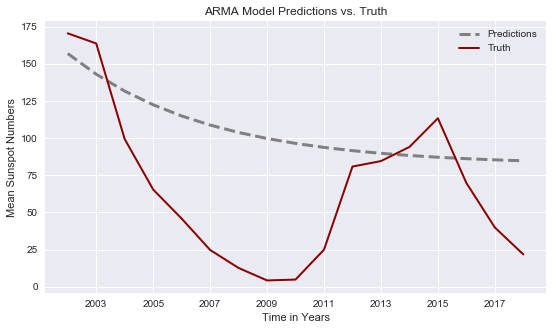

In [69]:
plt.subplots(figsize=(8,5))
plt.plot(truth.index, predictions_oos, lw=3, color='grey', ls='dashed',label='Predictions')
plt.plot(truth.index, truth.values,lw=2, color='darkred', label='Truth')
plt.title('ARMA Model Predictions vs. Truth')
plt.xlabel('Time in Years')
plt.ylabel('Mean Sunspot Numbers')
plt.legend()

# [Part 4: Using Yearly Average Sunspot Numbers for Model 2: SARIMAX](https://github.com/LeMaylon/capstone/blob/master/Capstone_Part_5_20180717.ipynb)

# Note: The link above will bring you back to the main notebook.